# <center> RESPIRATION RATE ESTIMATION
 
 **08/02/2023**   
    
 **Group 7:** **Giovanni Zago**, **Enrico Lupi**, **Emanuele Sarte**, **Alessio Saccomani** 
 
   The aim of this project is to estimate the Respiratory Rate (RR) by Seismocardiography(SCG), a technique where the detector is positioned above sternum, and Ballistocardiography (BCG), in which there is no contact between the sensor and the body: in this study the sensor was placed....). The measurements were taken using the detector MuSe (Multi-sensor miniaturized, low-power, wireless Inertial Measurement Unit), provided by 221e (https://www.221e.com). An IMU is a combination of an accelerometer and a gyroscope sensor, capable of detecting movements and measuring their intensity in terms of acceleration and rotational speeds. Sometimes, like in this case, a magnetometer is also included. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://www.221e.com/wp-content/uploads/2022/10/221e-Muse1.jpg", width=400, height=300)


In [2]:
Image(url= "https://embeddedinventor.com/wp-content/uploads/2019/07/imu1.jpg?ezimgfmt=ng:webp/ngcb7")

# Download Data and First Steps

First, we import the necessary libraries for the analysis (pandas, numpy, matplotlib, scipy, ecc.). 

We then download the datafile 'center_sternum.txt' as a pandas dataframe. For the following analysis we decide to take into account the linear acceleration (in mg), the angular velocity (in degrees per second) and the magnetic field (in mG) in all three directions; the quaternions are not considered, instead, so they are dropped. Afterwards, we calibrate the measurements using the information in the file README_1.txt and we addto the dataset the absolute time at which every measuremnt is taken: as the data collection frequency is 200 Hz, each measurement is taken every 5 ms. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import fft
from scipy import signal
from scipy import optimize
from scipy import linalg
import seaborn as sns
import pywt

In [6]:
file_name = "center_sternum.txt"
raw_data = pd.read_csv(file_name, sep="\t")

# We drop the columns we are not going to use
raw_data = raw_data.drop(["Log Mode", "qw", "qi", "qj", "qk"], axis=1)

# We look that the data collection frequency is the same for all the dataset
if len(raw_data["Log Freq"].unique()) != 1:
    print("There is more than a frequency")
    exit(1)

# We select the frequency (200 Hz)
ACQ_FREQ = raw_data.loc[0, "Log Freq"] #type: int

# We create a column with the absolute time by multiplying 1/200 s by integers
raw_data.insert(2, "Abs Time", np.arange(0, len(raw_data)) * (1 / ACQ_FREQ), allow_duplicates=False)

display(raw_data)


,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,200,1576222772,0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,200,1576222772,0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,200,1576222772,0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,200,1576222772,0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,200,1576222772,0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...,...,...,...
16501,200,1576222847,82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,200,1576222847,82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,200,1576222847,82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,200,1576222847,82.520,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


In [8]:
#calibrate the dataset
offset_gyro = np.array([-2.242224, 2.963463, -0.718397])
calibration_acc = np.array([[1.000966, -0.002326418, -0.0006995499],
                            [-0.002326379, 0.9787045, -0.001540918],
                            [-0.0006995811, -0.001540928, 1.00403]])
offset_acc = np.array([-3.929942, -13.74679, 60.67546])
calibration_magn = np.array([[0.9192851, -0.02325168, 0.003480837],
                             [-0.02325175, 0.914876, 0.004257396],
                             [0.003481006, 0.004257583, 0.8748001]])
offset_magn = np.array([-95.67974, -244.9142, 17.71132])

raw_data[['AccX', 'AccY', 'AccZ']] = np.dot(raw_data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc.T
raw_data[['GyroX', 'GyroY', 'GyroZ']] = raw_data[['GyroX', 'GyroY', 'GyroZ']] + offset_gyro.T
raw_data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(raw_data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn.T

display(raw_data)

,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,200,1576222772,0.000,938.943285,385.446046,190.172676,-11.308876,-8.317354,-0.032214,-542.004015,-859.069685,-110.879368
1,200,1576222772,0.005,961.263067,339.421058,208.674360,1.698758,-6.363154,-9.406260,-541.997869,-859.062146,-110.114062
2,200,1576222772,0.010,981.786120,332.229418,198.460686,7.225472,0.965094,-8.887176,-541.997869,-859.062146,-110.114062
3,200,1576222772,0.015,946.822847,368.469781,208.048504,13.393412,8.446010,-7.421527,-541.906458,-860.729721,-109.363834
4,200,1576222772,0.020,963.997411,377.645755,219.616964,20.736922,11.331506,2.578473,-541.906458,-860.729721,-109.363834
...,...,...,...,...,...,...,...,...,...,...,...,...
16501,200,1576222847,82.505,951.212844,247.295697,64.660873,-2.820326,8.232270,-2.108550,-577.257874,-822.632550,-71.020244
16502,200,1576222847,82.510,947.369951,244.377731,69.349018,-3.003532,8.415476,-2.139084,-577.209095,-823.462568,-70.262477
16503,200,1576222847,82.515,960.091200,246.699915,54.995987,-3.369944,9.300972,-2.337557,-577.209095,-823.462568,-70.262477
16504,200,1576222847,82.520,958.321473,256.617610,62.653314,-3.782158,9.591048,-3.024580,-578.133852,-821.737283,-69.488240


# Data Visualization

We now plot the accelerations, the angular velocity and the magnetic field components as a function of time in order to look at their general trend and to select a proper time window to conduct the analysis in. This is necessary as signals are very disturbed at the beginning and end of the data taking, probably due to sudden movements of the test subject: they are ususally used to coordinate the data taking across various devices, but they mud the data and need of course to be eliminated. 

From 10 to 65 seconds all features have a regular behaviour and thus we select this to be the time window to be used in the rest of the project. In the plots this time window is highlighted.

In [ ]:

# # labels = ["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ"]
# Nvar = len(labels)

# fig, axs = plt.subplots(Nvar, 2, figsize=(18, 4 * Nvar))
# for i in range(2):
#     for j in range(Nvar):

#         if i == 0:
#             x_range = raw_data["Abs Time"]
#             data_range = raw_data[labels[j]]
#         else:
#             ixmin, ixmax = (20 * ACQ_FREQ - 50,  24 * ACQ_FREQ + 50)
#             data_range = raw_data.loc[ixmin:ixmax ,labels[j]]
#             x_range = raw_data.loc[ixmin:ixmax, "Abs Time"]
#             axs[j][i].set_xlim(20, 24)

#         axs[j][i].plot(x_range, data_range, label=labels[j])
#         axs[j][i].set_xlabel("Time [s]")
#         axs[j][i].set_ylabel("Magnitude")
#         axs[j][i].legend(loc="best")



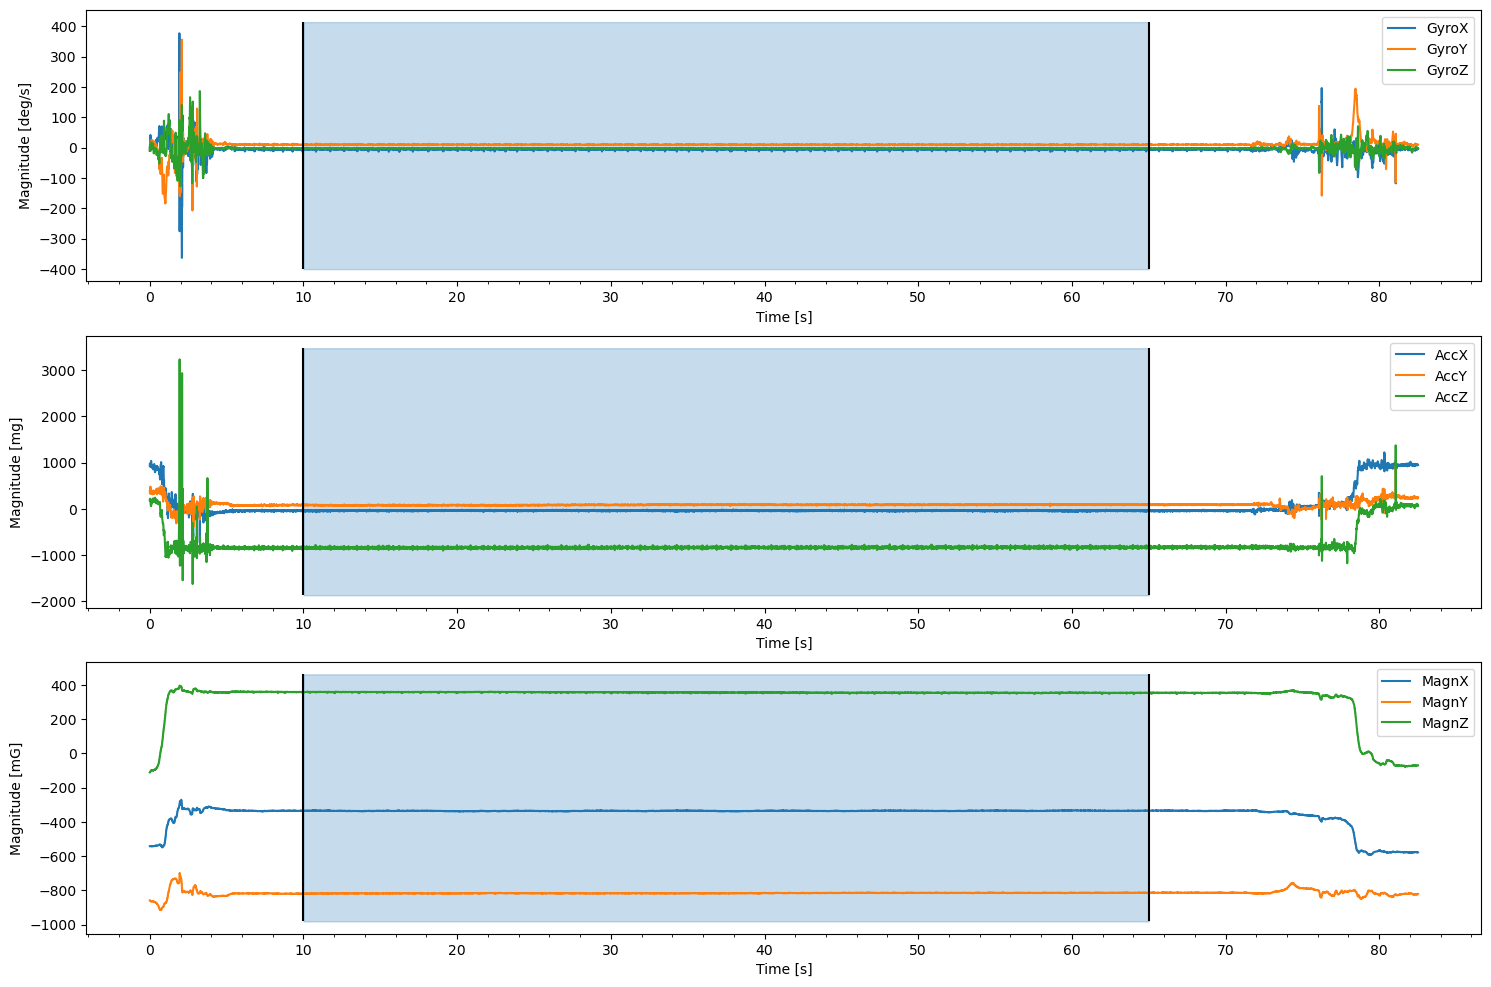

,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,200,1576222781,10.000,-39.757943,83.931682,-840.181573,-2.728723,10.949827,-2.245954,-335.784897,-822.072943,357.828825
2001,200,1576222781,10.005,-26.223359,83.398131,-858.154662,-2.927196,10.125399,-2.520763,-335.784897,-822.072943,357.828825
2002,200,1576222781,10.010,-34.565530,81.658407,-830.588868,-3.553150,10.247537,-2.536031,-335.091740,-819.633059,354.796365
2003,200,1576222781,10.015,-28.901844,84.835324,-827.101958,-3.537883,10.064330,-2.703970,-335.091740,-819.633059,354.796365
2004,200,1576222781,10.020,-39.579040,88.924194,-810.558578,-3.461547,10.629216,-2.429160,-335.821383,-821.227848,358.601669
...,...,...,...,...,...,...,...,...,...,...,...,...
12996,200,1576222831,64.980,-47.789400,87.869880,-835.755389,-5.614219,9.942193,-1.955878,-334.514189,-814.665427,353.317133
12997,200,1576222831,64.985,-40.209330,87.542902,-835.765040,-5.598952,9.514712,-2.154351,-334.544530,-813.812794,354.855283
12998,200,1576222831,64.990,-32.377294,89.297667,-848.264596,-6.041700,9.865857,-2.078015,-334.544530,-813.812794,354.855283
12999,200,1576222831,64.995,-49.777267,90.229611,-820.940524,-6.056967,9.942193,-2.490229,-335.396314,-813.777699,354.083831


In [12]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

labels = ["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ", "MagnX", "MagnY", "MagnZ"]
unit = ["[deg/s]", "[mg]", "[mG]"]
Nvar = len(labels)

T1_CUT = 10     
IT1_CUT = round(T1_CUT * ACQ_FREQ)
T2_CUT = 65 # included
IT2_CUT = round(T2_CUT * ACQ_FREQ) + 1

plt.figure(figsize=(18, 4 * (Nvar // 3)))
for i in range(Nvar // 3):
    ax = plt.subplot(Nvar // 3, 1, i + 1)
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3]],     label=labels[i * 3])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 1]], label=labels[i * 3 + 1])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 2]], label=labels[i * 3 + 2])
    ymin, ymax = plt.ylim()
    plt.vlines(x=raw_data.loc[IT1_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")
    plt.vlines(x=raw_data.loc[IT2_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")

    ax.fill_between(raw_data.loc[IT1_CUT: IT2_CUT, "Abs Time"], ymin, ymax, color='C0', alpha=0.25)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.xlabel("Time [s]")
    plt.ylabel("Magnitude "+unit[i])
    plt.legend()

plt.show()

raw_data_cut = raw_data.loc[IT1_CUT: IT2_CUT - 1, :]
display(raw_data_cut)

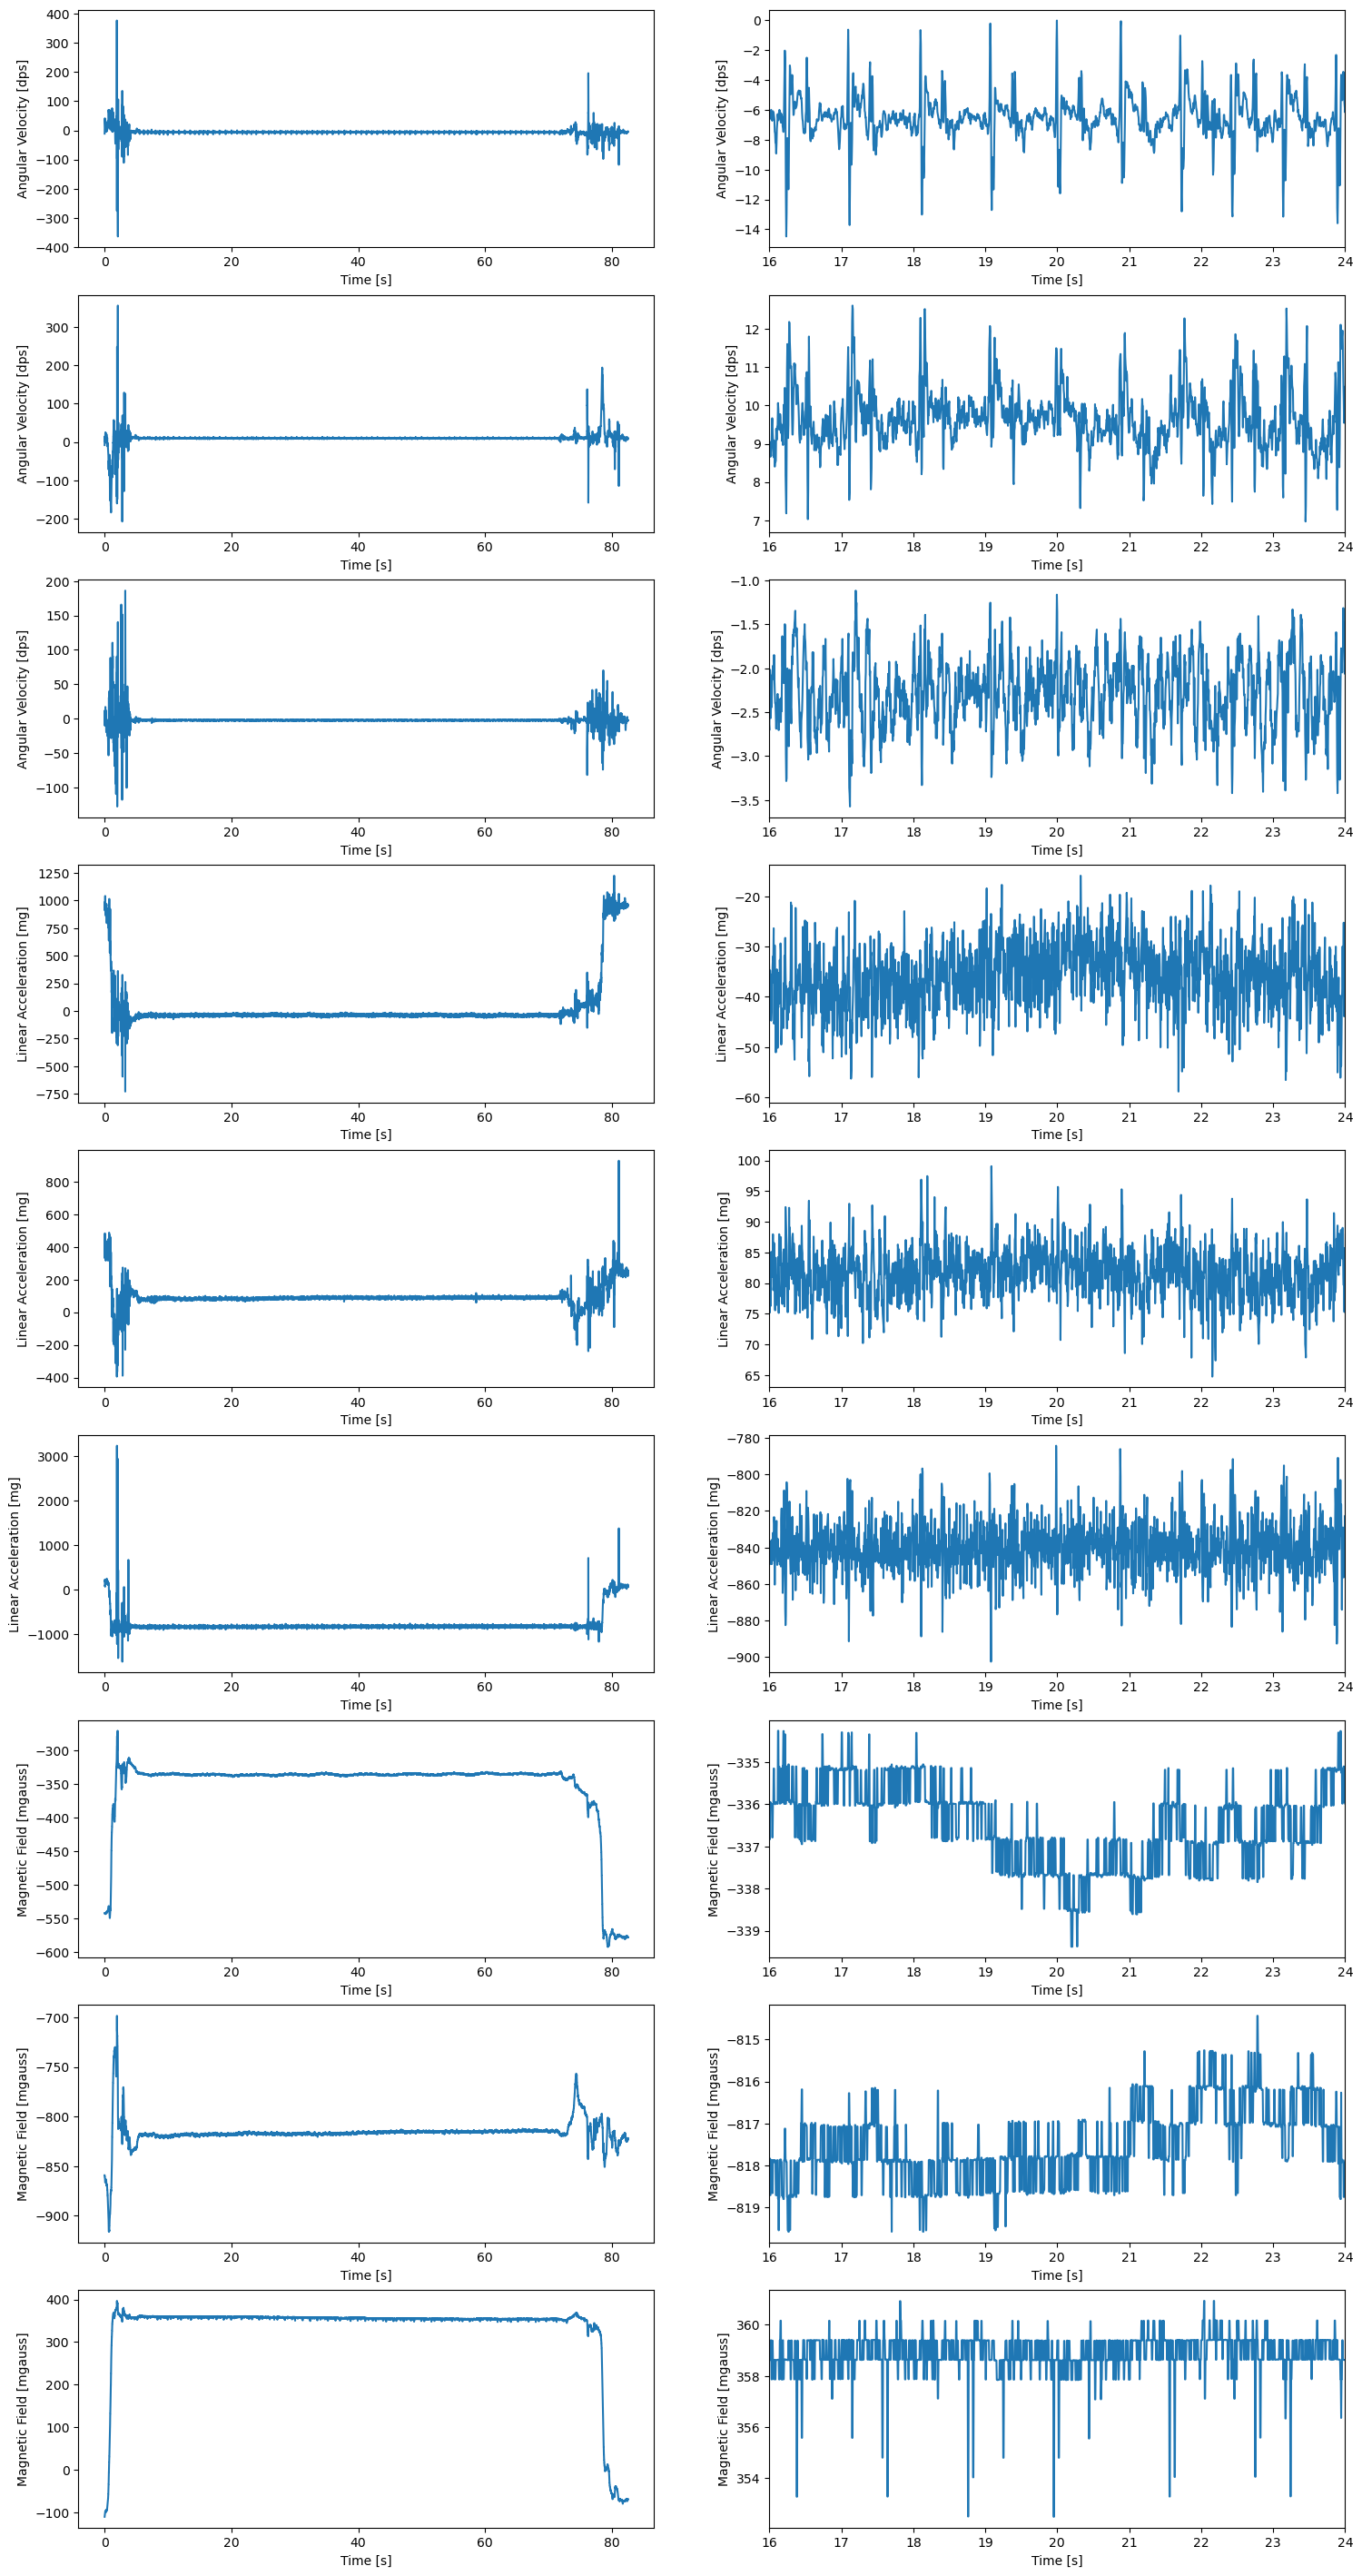

In [13]:

fig, axs = plt.subplots(Nvar, 2, figsize=(18, 4 * Nvar))
for i in range(2):
    for j in range(Nvar):
        if i == 0:
            x_range = raw_data["Abs Time"]
            data_range = raw_data[labels[j]]
        else:
            xmax, xmin = 16, 24
            ixmin, ixmax = (xmax * ACQ_FREQ - 50,  xmin * ACQ_FREQ + 50)
            data_range = raw_data.loc[ixmin:ixmax ,labels[j]]
            x_range = raw_data.loc[ixmin:ixmax, "Abs Time"]
            axs[j][i].set_xlim(xmax, xmin)

        axs[j][i].plot(x_range, data_range, label=labels[j]) #c='b' ?
        axs[j][i].set_xlabel("Time [s]")

        if "Acc" in labels[j]:
            axs[j][i].set_ylabel("Linear Acceleration [mg]")
        elif "Gyro" in labels[j]:
            axs[j][i].set_ylabel("Angular Velocity [dps]")
        elif "Magn" in labels[j]:
            axs[j][i].set_ylabel("Magnetic Field [mgauss]")

        # axs[j][i].legend(loc="best")


# Statistical Analysis

We calculate the mean, standard deviation, minimum, 25th, 50th, 75th percentiles and maximum for all features (in the selected time window); data is then normalized. 
For the accelerations and the angular velocities the 25th and 75th percentiles are nearly symmetric, so the variables change quite regularly, while we notice a higher deviation for the acceleration along X and the angular velocity along Z. 

Afterwards, normalized data is plotted in a 9x9 grid in order highlight possible correlations.

In [18]:
raw_data_cut.drop(["Log Freq", "Timestamp", "Abs Time"], axis=1).describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000
mean,-37.697898,86.219080,-835.916847,-6.561568,9.615171,-2.305126,-335.807245,-816.608375,356.346696
std,7.046675,5.113242,14.511361,1.425395,0.717895,0.364948,1.097665,1.417830,2.201973
min,-74.138361,58.061455,-902.437908,-14.484448,6.430743,-3.940611,-339.380611,-822.072943,347.181005
25%,-42.342979,82.817679,-844.496367,-7.171471,9.209369,-2.551298,-336.794919,-817.842526,354.800543
50%,-37.588226,86.373353,-836.354190,-6.637120,9.560514,-2.291756,-335.991913,-816.333003,356.343446
75%,-33.018319,89.591460,-828.159236,-5.950097,9.926926,-2.062748,-335.158567,-815.445275,358.621500
max,-12.506994,116.780481,-765.558650,-0.011166,13.484178,-0.795573,-331.922351,-812.854877,360.938064


In [19]:
data_std = (raw_data_cut[labels] - np.mean(raw_data_cut[labels], axis=0)) / np.std(raw_data_cut[labels], axis=0)
data_std.insert(0, "Abs Time", raw_data_cut["Abs Time"])
data_std.set_index(np.arange(0, len(data_std)), inplace=True)
display(data_std)

,Abs Time,GyroX,GyroY,GyroZ,AccX,AccY,AccZ,MagnX,MagnY,MagnZ
0,10.000,2.689093,1.859209,0.162144,-0.292356,-0.447368,-0.293902,0.020360,-3.854353,0.673122
1,10.005,2.549846,0.710761,-0.590898,1.628436,-0.551720,-1.532511,0.020360,-3.854353,0.673122
2,10.010,2.110682,0.880902,-0.632736,0.444537,-0.891974,0.367176,0.651872,-2.133416,-0.704096
3,10.015,2.121393,0.625690,-1.092929,1.248313,-0.270634,0.607475,0.651872,-2.133416,-0.704096
4,10.020,2.174950,1.412590,-0.339885,-0.266967,0.529065,1.747556,-0.012881,-3.258277,1.024116
...,...,...,...,...,...,...,...,...,...,...
10996,64.980,0.664652,0.455550,0.957024,-1.432159,0.322863,0.011127,1.178059,1.370430,-1.375903
10997,64.985,0.675364,-0.139942,0.413159,-0.356416,0.258913,0.010462,1.150417,1.971823,-0.677338
10998,64.990,0.364735,0.349212,0.622338,0.755086,0.602109,-0.850941,1.150417,1.971823,-0.677338
10999,64.995,0.354024,0.455550,-0.507227,-1.714272,0.784378,1.032088,0.374385,1.996576,-1.027700


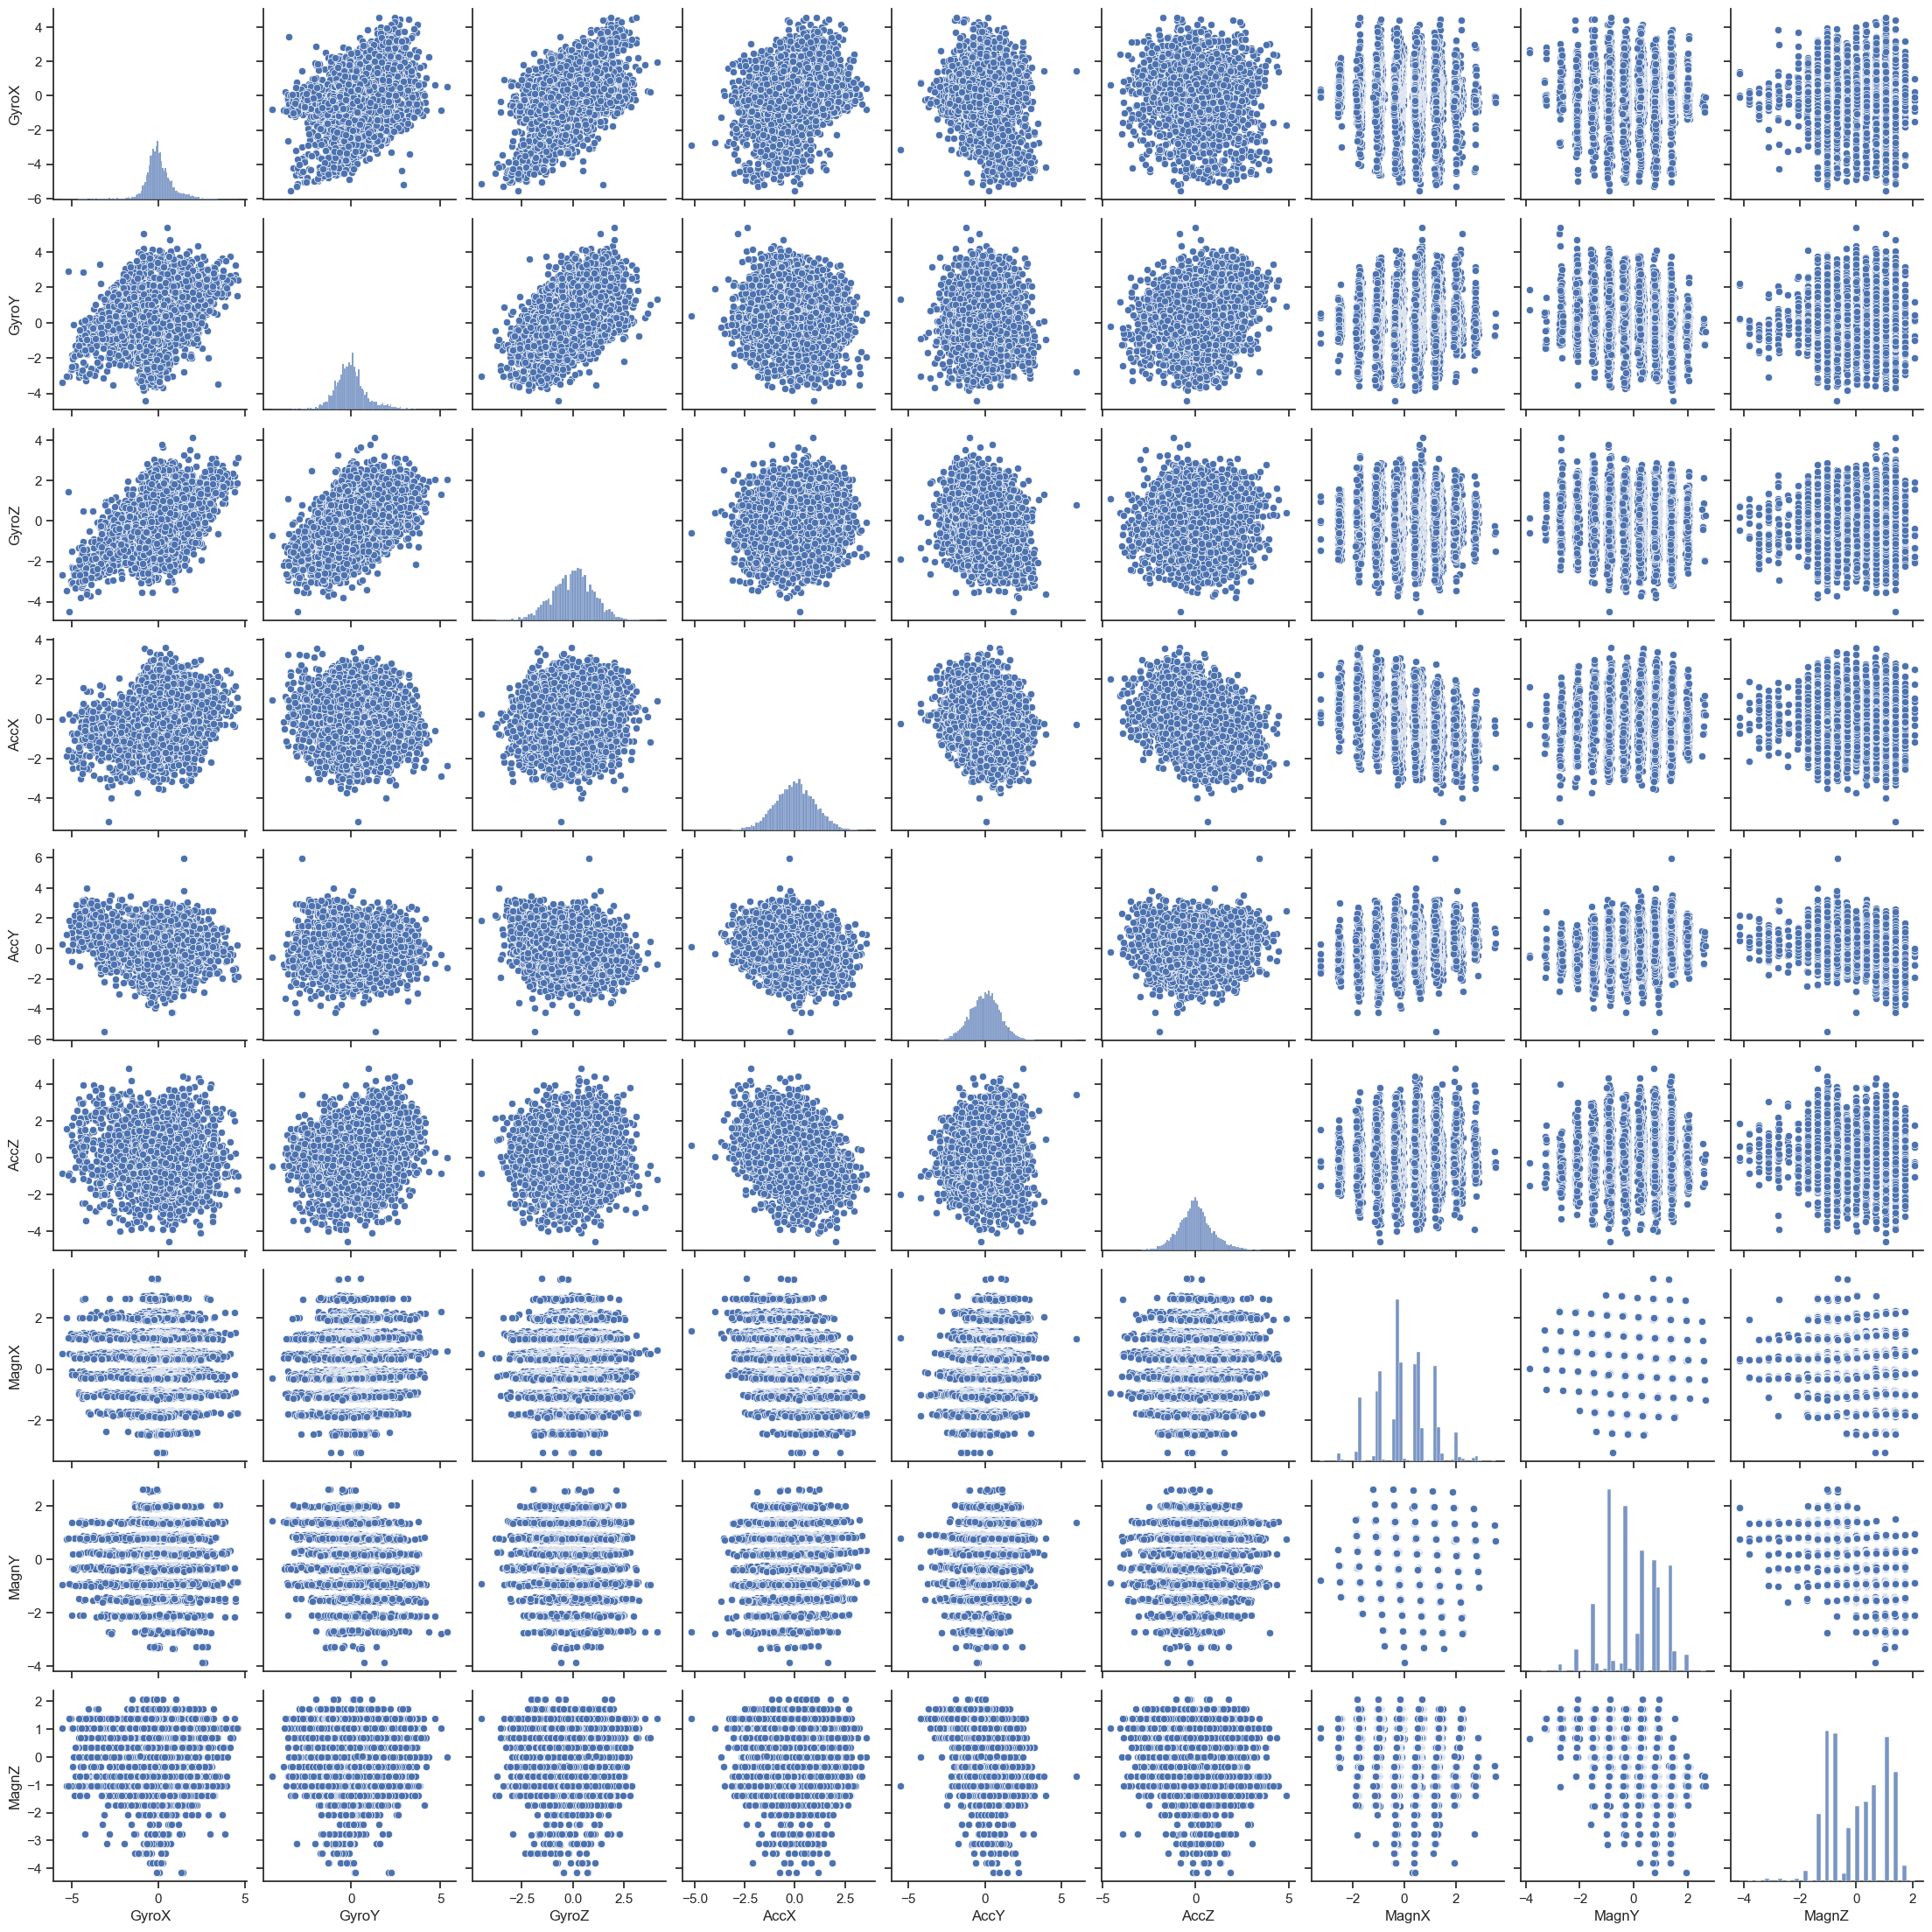

In [20]:
sns.set_theme(style="ticks")
sns.pairplot(data_std[labels])

# PCA

In order to reduce the dimensionality of the dataset we perform a PCA, keeping only 6 out of the total 9 principal components so as to maintain at least 85% of the total variability.

In [22]:
avls, avts = linalg.eig(np.cov(data_std[labels].T))
sort_perm = np.flip(np.argsort(avls))

avls = np.real_if_close(avls[sort_perm])
avts = avts[:, sort_perm]

var_ratios = avls / np.sum(avls)
print('Eigenvalues:\n', np.round(avls, 4)) #todo tenere la troncatura?
print('Variability ratios:\n', np.round(var_ratios * 100, 2))
print("Eigenvector:")
display(pd.DataFrame(avts, columns=[f"Avt {i+1}" for i in range(len(avls))]))

Eigenvalues:
 [2.4363 1.7777 1.3898 0.9014 0.733  0.5774 0.5301 0.4063 0.2488]
Variability ratios:
 [27.07 19.75 15.44 10.01  8.14  6.42  5.89  4.51  2.76]
Eigenvector:


,Avt 1,Avt 2,Avt 3,Avt 4,Avt 5,Avt 6,Avt 7,Avt 8,Avt 9
0,0.192443,0.513972,0.199332,0.129979,-0.178904,-0.713708,-0.303455,0.087979,0.030984
1,0.132141,0.580292,-0.119769,-0.034282,-0.265296,0.249127,0.628362,0.314411,-0.064351
2,0.157794,0.553909,-0.025734,-0.025690,0.425741,0.476218,-0.438999,-0.252312,-0.050435
3,0.296849,-0.031471,0.635831,-0.048267,-0.038445,0.004573,0.358587,-0.603227,-0.101551
4,-0.423876,0.089259,0.129071,0.158788,-0.719384,0.292945,-0.304762,-0.190128,-0.195269
5,-0.287113,0.170342,-0.400611,-0.658759,-0.042540,-0.276375,0.098703,-0.447752,-0.075368
6,-0.331562,0.124658,-0.277050,0.697381,0.252045,-0.179889,0.277781,-0.347396,-0.133033
7,-0.454446,0.074033,0.414867,-0.174048,0.339128,-0.074261,0.044149,0.328154,-0.596183
8,0.503912,-0.182440,-0.339055,0.055955,-0.130462,-0.040968,-0.100189,-0.029366,-0.751731


In [24]:
PCA_LABELS = [f"PC{i+1}" for i in range(len(avls))]
data_rot = pd.DataFrame(data=np.dot(avts.T, data_std[labels].T).T, columns=PCA_LABELS)

perc_thr = .85
N_PCA = np.argmax(np.cumsum(var_ratios) >= perc_thr) + 1

print(f'To keep {int(perc_thr * 100)}% of variability in our dataset we need {N_PCA} out of the {len(var_ratios)} principal components')

display(data_rot)

PCA_LABELS = PCA_LABELS[:N_PCA]
data_pca = data_rot[data_rot.columns[:N_PCA]]
data_pca.insert(0, "Abs Time", data_std["Abs Time"])
display(data_pca)


To keep 85% of variability in our dataset we need 6 out of the 9 principal components


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,3.060025,2.064406,-1.649625,1.141012,-1.949531,-1.175005,0.051603,-0.118422,1.883884
1,3.732683,0.628532,0.183578,1.888293,-1.886626,-1.399809,0.301121,-0.886001,1.910123
2,1.225956,1.266245,-0.475024,0.641949,-0.739071,-1.879007,0.815717,-0.546533,1.856461
3,1.027914,0.939845,0.064516,0.565479,-1.357310,-2.050102,0.976707,-1.220307,1.675362
4,1.747377,1.672956,-2.223863,-0.195903,-2.595071,-1.489112,0.042315,-1.095594,0.960106
...,...,...,...,...,...,...,...,...,...
10996,-1.932787,1.711185,-0.111427,0.665298,0.931179,-0.077492,-0.420831,0.838651,0.085126
10997,-1.660722,0.943834,0.672333,0.554578,0.966222,-0.574424,-0.205454,0.339564,-0.825493
10998,-1.191060,1.032817,1.642558,1.060362,0.728103,0.212441,0.313298,0.063208,-0.992112
10999,-2.638733,0.847099,-0.300116,-0.573090,-0.036877,-0.617548,-0.055294,1.280503,-0.517206


,Abs Time,PC1,PC2,PC3,PC4,PC5,PC6
0,10.000,3.060025,2.064406,-1.649625,1.141012,-1.949531,-1.175005
1,10.005,3.732683,0.628532,0.183578,1.888293,-1.886626,-1.399809
2,10.010,1.225956,1.266245,-0.475024,0.641949,-0.739071,-1.879007
3,10.015,1.027914,0.939845,0.064516,0.565479,-1.357310,-2.050102
4,10.020,1.747377,1.672956,-2.223863,-0.195903,-2.595071,-1.489112
...,...,...,...,...,...,...,...
10996,64.980,-1.932787,1.711185,-0.111427,0.665298,0.931179,-0.077492
10997,64.985,-1.660722,0.943834,0.672333,0.554578,0.966222,-0.574424
10998,64.990,-1.191060,1.032817,1.642558,1.060362,0.728103,0.212441
10999,64.995,-2.638733,0.847099,-0.300116,-0.573090,-0.036877,-0.617548


# Fourier Analysis

We then perform a Fourier analysis using the scipy fftpack library in order to extrapolate the principal frequencies of the data and see if a peak is present near the respiratory rate (around 0.2 Hz).

We first plot as an example the whole power spectrum of PC3: we can clearly see a peak around 0.2 Hz due to respiration and one around 1.1 Hz corresponding to the heart rate, while the peaks at high frequencies are due to noise. As we are only interested in the respiratory rate, all following plots will be focused only in the [0, 0.9] Hz range.

In [31]:
sig_fft = fft.fftshift(fft.fft(data_pca[PCA_LABELS], axis=0))
sample_freq = fft.fftshift(fft.fftfreq(len(data_pca), d=1/ACQ_FREQ))

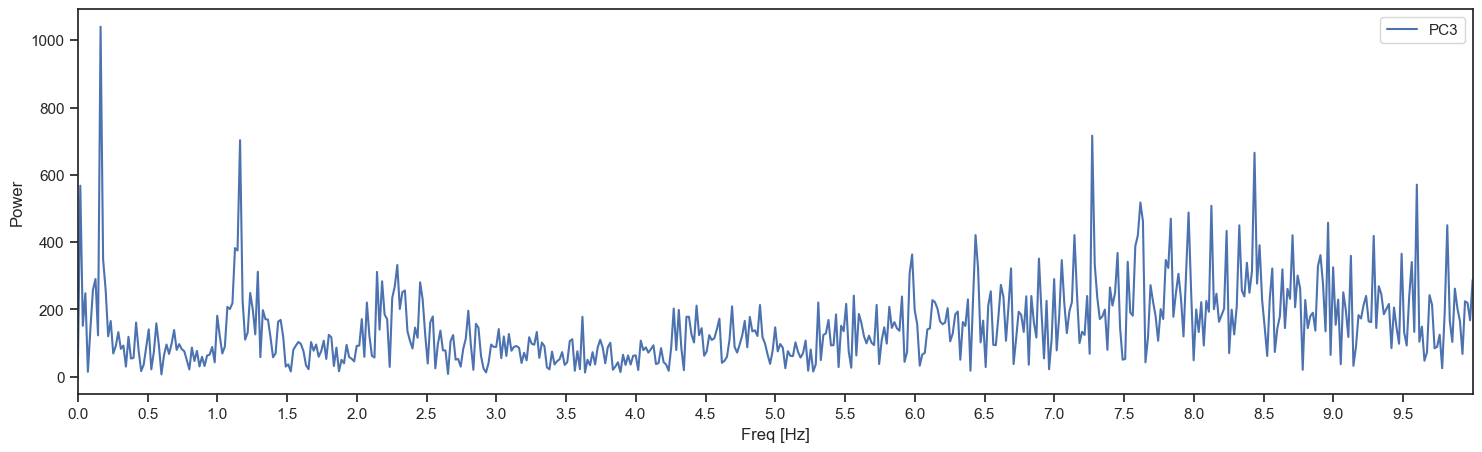

In [40]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(sample_freq, np.abs(sig_fft[:, 2]), label=PCA_LABELS[2])
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 10, 0.5))
plt.xlabel("Freq [Hz]")
plt.ylabel("Power")
plt.legend(loc="best")

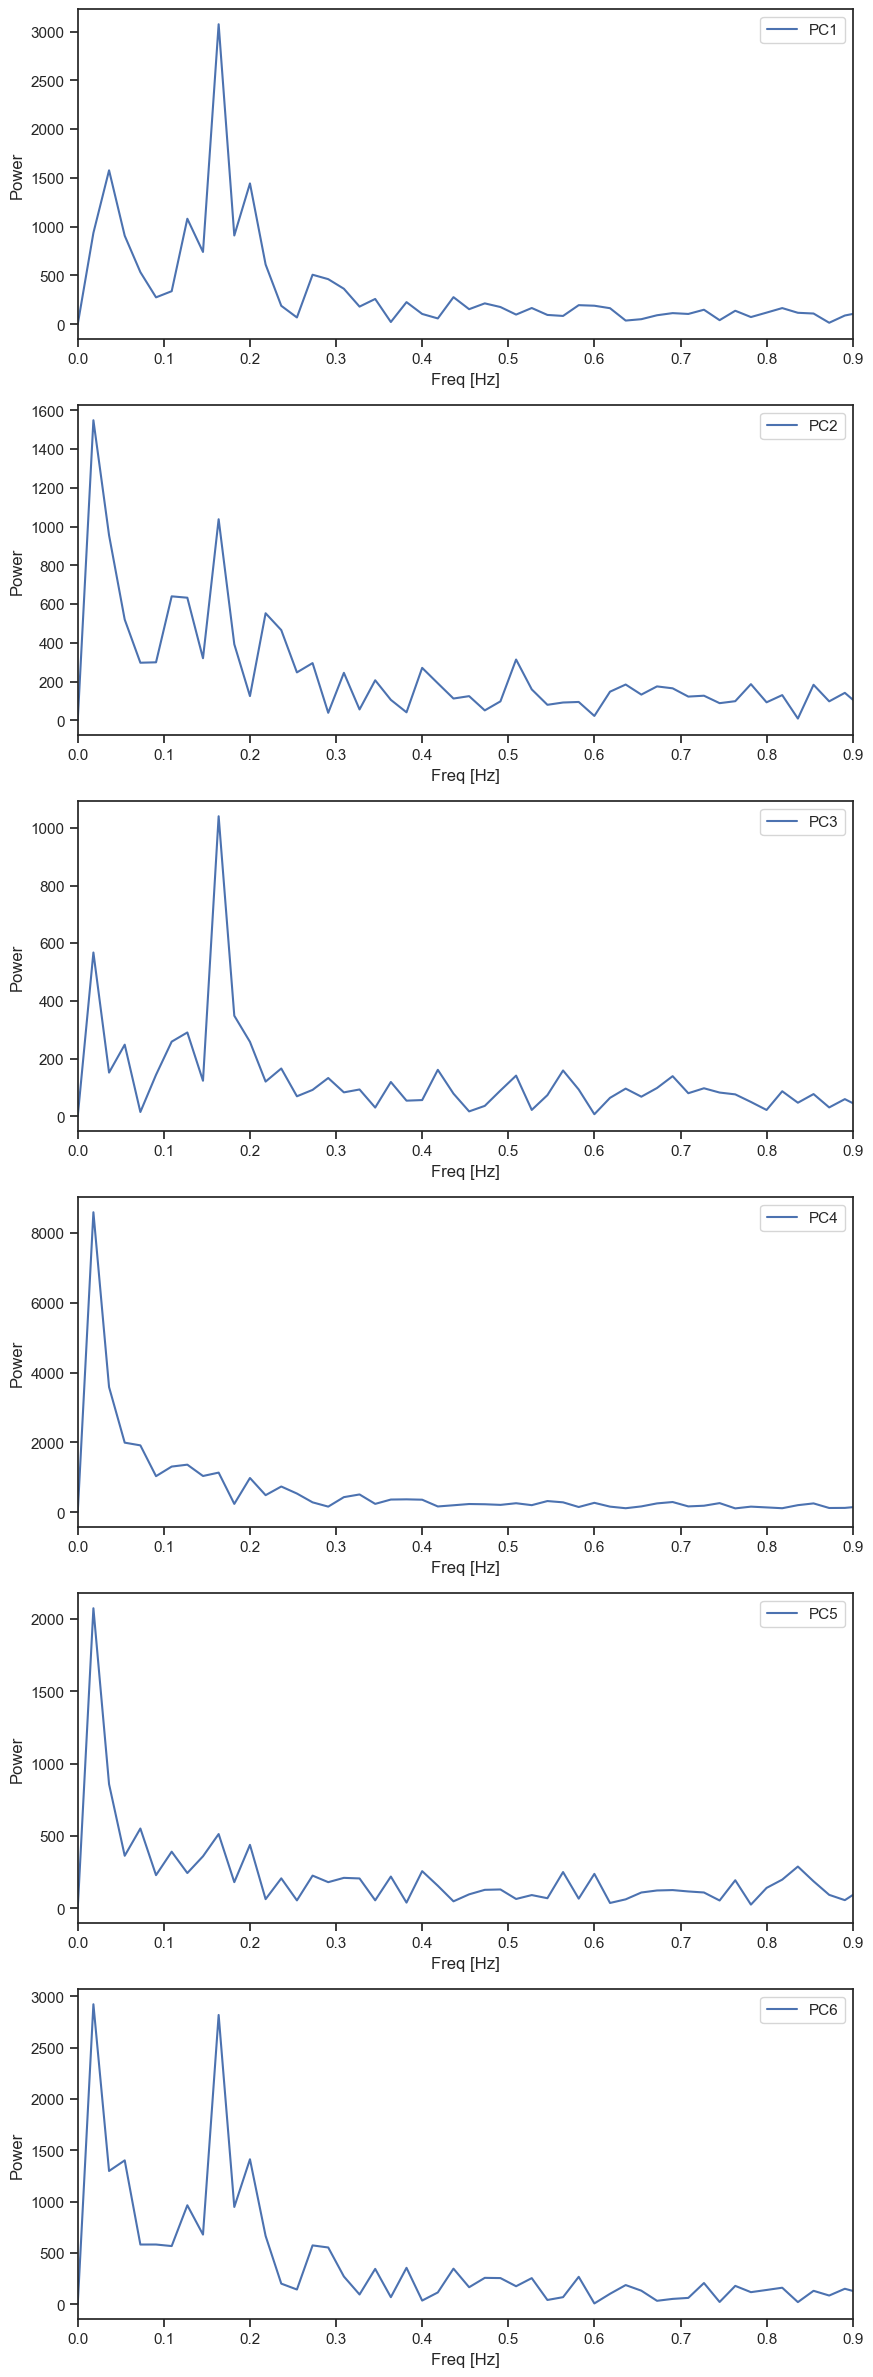

In [44]:
plt.figure(figsize=(10, 5 * N_PCA))
for i in range(N_PCA):
    ax = plt.subplot(N_PCA, 1, i+1)
    plt.plot(sample_freq, np.abs(sig_fft[:, i]), label=PCA_LABELS[i])
    ax.set_xlim(0, 0.9)
    plt.xticks(np.arange(0, 1, 0.1))
        
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Power")
    plt.legend(loc="best")
    

TypeError: 'list' object is not callable

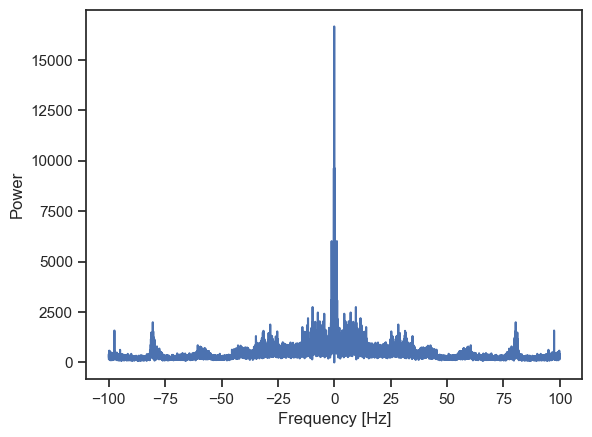

In [47]:
total_FFT = np.sum(np.abs(sig_fft), axis=1)
plt.plot(sample_freq, total_FFT)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.xlim(left=0, right=1)

Let's now perform a wavelet transform analysis

In [ ]:
pywt.dwt_max_level(len(data_pca), "sym5")

In [ ]:
#Filter signal using wavelets
#We used db2, with a high decomposition level 
#as we are interested only in low frequencies but we want to exclude those near zero
#we will thus use the last three detail coefficients to
#cover ranges [0.098, 0.78125] Hz 

lvl = 0
if file_name == "center_sternum.txt":
    lvl = 10
else:
    lvl = 9

coeffs = pywt.wavedec(data_pca[PCA_LABELS], "sym5", level=lvl, axis=0)
coeffs[0] = np.zeros_like(coeffs[0])
for i in range(3, lvl + 1):
    coeffs[i] = np.zeros_like(coeffs[i])

A10 = pywt.waverec(coeffs, "sym5", axis=0)


In [ ]:
#plot only approximation wavelet
fig, axs = plt.subplots(nrows=N_PCA, ncols=2, figsize=(18, N_PCA*5))

for i in range(N_PCA):
    for j in range(2):
        #axs[i][j].plot(data_std["Abs Time"], data_std[labels[i]], label=("Original "+labels[i]))
        #axs[i][j].plot(data_std["Abs Time"], filtered[i], label=("Butterworth "+labels[i]))
        #axs[i][j].plot(data_std["Abs Time"], A7[i][:-1],  label=("Butterworth+Wavelet "+labels[i]))
        axs[i][j].plot(data_pca["Abs Time"], A10[:-1, i], label=("Wavelet "+PCA_LABELS[i]))
        if j == 1:
            axs[i][j].set_xlim([20,24])
        
        axs[i][j].set_xlabel("Time [s]")
        axs[i][j].set_ylabel("Magnitude") # ???
        axs[i][j].legend(loc="best")
    

In [ ]:
sig_fft_wt = fft.fftshift(fft.fft(A10[:-1, :], axis=0))
sample_freq = fft.fftshift(fft.fftfreq(len(data_pca), d=1/ACQ_FREQ))

plt.figure(figsize=(18, 5 * N_PCA))
for i in range(N_PCA):
    for j in range(2):
        ax = plt.subplot(N_PCA, 2, i * 2 + j + 1)
        plt.plot(sample_freq, np.abs(sig_fft[:, i]), label=PCA_LABELS[i])
        plt.plot(sample_freq, np.abs(sig_fft_wt[:, i]),
                 label="Approximated " + PCA_LABELS[i])
        if j == 0:
            plt.xlim([0, 3])
        else:
            plt.xlim([0, 1])
            plt.xticks(np.arange(0, 1, 0.1))

        plt.xlabel("Freq [Hz]")
        plt.ylabel("Power")
        plt.legend(loc="best")


# Metrics

### Detection of the peaks

In [ ]:
A10=A10.T
peaks = []
valleys = []
for i in range(len(A10)):
    temp_signal = A10[i][:-1]
    temp_peaks, _ = signal.find_peaks(temp_signal)
    temp_valleys, _ = signal.find_peaks(-temp_signal)
    peaks.append(temp_signal[temp_peaks])
    peaks.append(data_std['Abs Time'].values[temp_peaks])
    valleys.append(temp_signal[temp_valleys])
    valleys.append(data_std['Abs Time'].values[temp_valleys])
    
fig, ax = plt.subplots(len(A10), 1, figsize=(20, 15))
for i in range(1, len(peaks), 2):    
    ax[int(i/2)].plot(data_std['Abs Time'], A10[int(i/2)][:-1])
    ax[int(i/2)].plot(peaks[i], peaks[i-1], 'x')

### Improve peak detection

In [ ]:
avg_peak_dist = []
for i in range(1, len(peaks), 2):    
    avg_peak_dist.append(len(data_std['Abs Time']) / len(peaks[i]))
print(avg_peak_dist)

sign_amp = []
for i in range(1, len(peaks), 2):
    temp_sign_amp = []    
    for j in range(np.min([len(peaks[i]), len(valleys[i])])):
        temp_peaks = np.array(peaks[i-1])
        temp_valleys = np.array(valleys[i-1])
        temp_sign_amp.append(0.5*np.abs(temp_peaks[j] + temp_valleys[j]))
    sign_amp.append(temp_sign_amp)

avg_sign_amp = np.empty(shape=(len(A10)))
for i,x  in enumerate(sign_amp):
    avg_sign_amp[i] = np.mean(x)

height_perc = .6
distance_perc = .7
peaks_refined = []
valleys_refined = []
for i in range(len(A10)):
    temp_signal = A10[i][:-1]
    temp_peaks, _ = signal.find_peaks(temp_signal, height = height_perc * avg_sign_amp[i], distance = distance_perc * avg_peak_dist[i])
    temp_valleys, _ = signal.find_peaks(-temp_signal)
    peaks_refined.append(temp_signal[temp_peaks])
    peaks_refined.append(data_std['Abs Time'].values[temp_peaks])
    valleys_refined.append(temp_signal[temp_valleys])
    valleys_refined.append(data_std['Abs Time'].values[temp_valleys])

fig, ax = plt.subplots(len(A10), 1, figsize=(20, 15))
for i in range(1, len(peaks_refined), 2):    
    ax[int(i/2)].plot(data_std['Abs Time'], A10[int(i/2)][:-1])
    ax[int(i/2)].plot(peaks_refined[i], peaks_refined[i-1], 'x')
    ax[int(i/2)].axhline(avg_sign_amp[int(i/2)] * height_perc, color='g')
    # ax[int(i/2)].plot(valleys_refined[i], valleys_refined[i-1], 'x')

### Generate histogram and perform gaussian fit to estimate RR

In [ ]:
time_dist = []
for i in range(1, len(peaks_refined), 2):
    temp_time_dist = []    
    for j in range(1, len(peaks_refined[i])):
        temp_peaks_time = peaks_refined[i]
        temp_time_dist.append(temp_peaks_time[j]-temp_peaks_time[j-1])
    time_dist.append(temp_time_dist)

time_dist = np.concatenate(time_dist)
print(len(time_dist))
original_mean = np.mean(time_dist)
print(original_mean)
original_std = np.std(time_dist)
print(original_std)

fig, ax = plt.subplots(figsize=(8,6))
bins = ax.hist(x=time_dist)
lower_sigma_tol = 2
upper_sigma_tol = 3
# ax.axvline(np.mean(time_dist) - lower_sigma_tol*original_std, color='r')
# ax.axvline(np.mean(time_dist) + upper_sigma_tol*original_std, color='r')

bin_centers = (bins[1][:-1] + bins[1][1:]) / 2
bin_counts = bins[0]

def myround(x):
    return round(x,1)

ax.set_xticks(bin_centers)
_=ax.set_xticklabels(map(myround,bin_centers))

def my_gaus(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x-mu)/sigma) ** 2)

params, params_cov = optimize.curve_fit(my_gaus, bin_centers, bin_counts, p0=[1, np.mean(time_dist), np.std(time_dist)], absolute_sigma=True, bounds=(0,[100, 100, 100]))
fit_domain = np.sort(np.random.uniform(np.min(bin_centers), np.max(bin_centers), 1000))
_=ax.plot(fit_domain, my_gaus(fit_domain, *params))

print('Fit parameters:\n',params)
print('Fit parameters errors:\n', np.sqrt(np.diag(params_cov)))

**Alternative method without filter**

When we have no filter we can consider the frequencies' range [0.1,0.4] and compute the respiration rate as the mean of the frequencies of the three max power in the fourier analysis for each of the six principal components

In [ ]:
sample_freqi = (sample_freq > 0.1) & (sample_freq < 0.4)
power_fft = np.abs(sig_fft)

freqi_maxs = np.argmax(power_fft[sample_freqi, :], axis=0)
freq_maxs = sample_freq[sample_freqi][freqi_maxs]
RR = np.mean(freq_maxs)

print(f"RPM is: {RR * 60:.2f}")

# Conclusions

## EXTRA

In [ ]:
#filter signal with Butterworth bandpass filter in [0.1,0.5] Hz range

freq=200
filtered = np.zeros((Nvar,len(data_std)))
sos = signal.butter(4, [0.1, 0.8], 'bandpass', fs=freq, output='sos')
for i in range(Nvar):
    filtered[i] = signal.sosfilt(sos, data_std[labels[i]])
    

In [ ]:
#plot filtered Gyro and Acc
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data_std["Abs Time"], data_std[labels[j]], label=labels[j])
        axs[j][i].plot(data_std["Abs Time"], filtered[j],         label=("Filtered "+labels[j]))
        if i == 1:
            axs[j][i].set_xlim([20,24])

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

In [ ]:
#calculate spectrum after filtering
sig_fft_filt = 1j*np.zeros((Nvar, len(data_std)))

for i in range(Nvar):
    sig_fft_filt[i] = fftpack.fft(filtered[i])

power_filt = np.abs(sig_fft_filt)

In [ ]:
#plot filtered spectrum
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],      label=labels[j])
        axs[j][i].plot(sample_freq, power_filt[j], label=("Filtered "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

In [ ]:
#Filter signal using wavelets
#We used db6 as it is smooth, with a decomposition level=7 
#as we are interested only in low frequencies, and the approximate coefficients at level J
#cover ranges [0, freq/2^(J+1)], so or the last decomposition [0, 0.78125] Hz
lvl = 0
if file_name == "center_sternum.txt":
    lvl = 7
else:
    lvl = 6
    
A7 = np.zeros((Nvar, len(data_std)+1))
for i in range(Nvar):
    coeffs = pywt.wavedec(filtered[i], "db6", level=lvl)
    for l in range(1, lvl+1):
        coeffs[l] = np.zeros_like(coeffs[l])
    A7[i] = pywt.waverec(coeffs, "db6") 
    


In [ ]:
#plot only approximation wavelet
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data_std["Abs Time"], A7[j][:-1], label=labels[j])
        if i == 1:
            axs[j][i].set_xlim([20,24])
        

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

In [ ]:
#calculate spectrum after wavelet
sig_fft_wt = 1j*np.zeros((Nvar, len(data_std)))

for i in range(Nvar):
    sig_fft_wt[i] = fftpack.fft(A7[i][:-1])

power_wt = np.abs(sig_fft_wt)

In [ ]:
#plot filtered spectrum
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],    label=labels[j])
        axs[j][i].plot(sample_freq, power_wt[j], label=("Approximated "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")